# Using the expression of genes on the X-chromosome to predict young or aged cells (4/5 -- final model over 50 random states)

## Outline

The **Xgene** workflow consists of four sections:

I. Exploratory data analysis (EDA) (1/5)

II. preprocessing and model tunning (2/5)

III. Model comparison (3/5)

IV. Final model over 50 random states (4/5, this notebook)

1. [Choose the best hyperparameter](#1.-choose)


2. [Run the model over 50 random states using the best hyperparameter](#2.-run)

V. Results and intepretations (5/5)

## 1. Choose the best hyperparameter<a name="1.-choose"></a>

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, ParameterGrid
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import pickle

import tqdm
from tqdm import tqdm

import xgboost
from xgboost import XGBClassifier

In [2]:
merged_features = pd.read_csv('snhypo_neuron_x_12.csv', index_col=0)
y = merged_features['target']

features = list(merged_features.columns)
features.remove('target')
features.remove('group')
X = merged_features[features]

In [3]:
cat_ftrs = ['tree.ident']

features = list(merged_features.columns)
features.remove('target')
features.remove('group')
cont_ftrs = features[1:-1]

categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

    # standard scaler for continuous feature
numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

preprocess = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])

In [93]:
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              #"seed": [0],
              #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"missing": [np.nan], 
              # "max_depth": [10],
              "colsample_bytree": [0.9],              
              "subsample": [0.66],
              "eval_metric": ['logloss']}



max_depth = [1, 2, 3, 4, 5, 8, 10, 15, 20]

train_scores = []
test_scores = []
cv_scores = []
max_depths = []

best_max = []
best_test = []

for i in tqdm(range(5)):
    train_scores_tmp = []
    test_scores_tmp = []
    cv_scores_tmp = []
    max_depths_tmp = []
    
    random_state = 42*i
    param_grid['seed'] = [random_state]
    # split the data to other and test (80-20)
    X_other, X_test, y_other, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=random_state)
    # Since the data is not group based, 
    # use KFold with 4 folds: 3/4 of the data points for training and
    # 1/4 of the data points for cross validation
   
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    X_test0 = pd.DataFrame(X_test)
    
    for train_idx, cv_idx in kfold.split(X_other): 
        X_train, X_cv = X_other.iloc[train_idx], X_other.iloc[cv_idx]
        y_train, y_cv = y_other.iloc[train_idx], y_other.iloc[cv_idx]
        
        X_train = preprocess.fit_transform(X_train)

        X_test = preprocess.transform(X_test0)
        X_cv = preprocess.transform(X_cv)
    
        for j in max_depth:
            param_grid['max_depth'] = [j]
            XGB = XGBClassifier()
            XGB.set_params(**ParameterGrid(param_grid)[0])
            XGB.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_cv, y_cv)], verbose=False)

            y_train_pred = XGB.predict(X_train)
            y_test_pred = XGB.predict(X_test)
            y_cv_pred = XGB.predict(X_cv)
            # Accumulate the training and validation scores into tmp arrays, 
            train_scores_tmp.append(accuracy_score(y_train,y_train_pred))
            test_scores_tmp.append(accuracy_score(y_test,y_test_pred))
            cv_scores_tmp.append(accuracy_score(y_cv,y_cv_pred))
            max_depths_tmp.append(j)
    
    # Accumulate the training and validation scores into arrays
    train_scores = train_scores + train_scores_tmp
    cv_scores = cv_scores + cv_scores_tmp
    
    test_scores = test_scores + test_scores_tmp
    max_depths = max_depths + max_depths_tmp
    
    
    
    # print out the best test score and the best max depth value
    print('\nrandom state: ', random_state)
    
    best_max.append(max_depths_tmp[np.argmax(cv_scores_tmp)])
    best_test.append(test_scores_tmp[np.argmax(cv_scores_tmp)])
    
    print('the best validation score: ', max(cv_scores_tmp), 
          ' when max depth = ', best_max[i],
         'with test score: ', best_test[i])

 20%|██        | 1/5 [12:57<51:49, 777.28s/it]


random state:  0
the best validation score:  0.7865  when max depth =  5 with test score:  0.7824435112977405


 40%|████      | 2/5 [25:18<37:48, 756.27s/it]


random state:  42
the best validation score:  0.8035491127218195  when max depth =  8 with test score:  0.7880423915216956


 60%|██████    | 3/5 [38:18<25:33, 766.99s/it]


random state:  84
the best validation score:  0.7855  when max depth =  8 with test score:  0.7832433513297341


 80%|████████  | 4/5 [51:01<12:45, 765.41s/it]


random state:  126
the best validation score:  0.7845  when max depth =  15 with test score:  0.764247150569886


100%|██████████| 5/5 [1:03:41<00:00, 764.26s/it]


random state:  168
the best validation score:  0.7833041739565109  when max depth =  5 with test score:  0.7710457908418317


In [115]:
# fit transform the features once, and store it
feature_names = cont_ftrs + list(preprocess.transformers_[1][1]['onehot'].get_feature_names())

file = open('./data/feature_names.save', 'wb')
pickle.dump((feature_names),file)
file.close()

mean_train: [0.77986351 0.82254888 0.86282436 0.90193248 0.95135501 0.99644019
 0.99945253 0.99999    0.9999925 ] 
std_train: [4.38182391e-03 5.90907112e-03 9.08403270e-03 1.64660868e-02
 1.53990122e-02 2.43215503e-03 4.59003865e-04 2.29114465e-05
 2.03092498e-05]
mean_val: [0.75504191 0.76942122 0.77392106 0.77643085 0.77799088 0.77920071
 0.77735073 0.77410102 0.77306103] 
std_val: [0.00687104 0.00660237 0.00565283 0.00621269 0.0063907  0.00738479
 0.0075123  0.00770836 0.00841634]


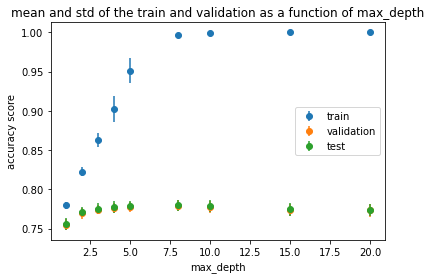

In [95]:
import matplotlib.pyplot as plt

depth = len(max_depth)

mean_train = np.zeros(depth)
std_train = np.zeros(depth)

mean_test = np.zeros(depth)
std_test = np.zeros(depth)

mean_cv = np.zeros(depth)
std_cv = np.zeros(depth)

train_scores = np.array(train_scores)
cv_scores = np.array(cv_scores)
test_scores = np.array(test_scores)
max_depths = np.array(max_depths)

for i in range(depth):
    mean_train[i] = np.mean(train_scores[max_depths == max_depth[i]])
    std_train[i] = np.std(train_scores[max_depths == max_depth[i]])
    
    mean_test[i] = np.mean(test_scores[max_depths == max_depth[i]])
    std_test[i] = np.std(test_scores[max_depths == max_depth[i]])

    mean_cv[i] = np.mean(cv_scores[max_depths == max_depth[i]])
    std_cv[i] = np.std(cv_scores[max_depths == max_depth[i]])
    
print('mean_train:', mean_train, '\nstd_train:', std_train)
print('mean_val:', mean_cv, '\nstd_val:', std_cv)

plt.errorbar(max_depth, mean_train, yerr=std_train, fmt='o', label='train')
plt.errorbar(max_depth, mean_cv, yerr=std_cv, fmt='o', label='validation')
plt.errorbar(max_depth, mean_test, yerr=std_test, fmt='o', label='test')

#plt.semilogx()
plt.title('mean and std of the train and validation as a function of max_depth')
plt.ylabel('accuracy score')
plt.xlabel('max_depth')
plt.legend()
plt.show()

## 2. Run the model over 50 random states using the best hyperparameter<a name="2.-run"></a>

In [4]:
file = open('./data/feature_names.save', 'rb')
feature_names = pickle.load(file)
file.close()

In [164]:
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              #"seed": [0],
              #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"missing": [np.nan], 
              "max_depth": [5],
              "colsample_bytree": [0.9],              
              "subsample": [0.66],
              "eval_metric": ['logloss']}


models = []
best_test = []
test_sets = []

for i in tqdm(range(50)):
    test_scores_tmp = []
    cv_scores_tmp = []
    models_tmp = []
    test_sets_temp = []
    
    random_state = 42*i
    param_grid['seed'] = [random_state]
    # split the data to other and test (80-20)
    X_other, X_test, y_other, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=random_state)
    # Since the data is not group based, 
    # use KFold with 4 folds: 3/4 of the data points for training and
    # 1/4 of the data points for cross validation
   
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    X_test0 = pd.DataFrame(X_test)
    
    for train_idx, cv_idx in kfold.split(X_other): 
        X_train, X_cv = X_other.iloc[train_idx], X_other.iloc[cv_idx]
        y_train, y_cv = y_other.iloc[train_idx], y_other.iloc[cv_idx]
        
        X_train = preprocess.fit_transform(X_train)
        df_train = pd.DataFrame(data=X_train,columns = feature_names)

        X_cv = preprocess.transform(X_cv)
        df_cv = pd.DataFrame(data=X_cv, columns = feature_names)
        
        X_test = preprocess.transform(X_test0)
        df_test = pd.DataFrame(data=X_test,columns = feature_names)

        
        XGB = XGBClassifier()
        XGB.set_params(**ParameterGrid(param_grid)[0])
        XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_cv, y_cv)], verbose=False)

        y_test_pred = XGB.predict(df_test)
        y_cv_pred = XGB.predict(df_cv)
        
        # Accumulate the training and validation scores into tmp arrays, 
        test_scores_tmp.append(accuracy_score(y_test,y_test_pred))
        cv_scores_tmp.append(accuracy_score(y_cv,y_cv_pred))
        models_tmp.append(XGB)
        test_sets_temp.append((df_test, y_test))
        
    # Accumulate the training and validation scores into arrays
    best_test.append(test_scores_tmp[np.argmax(cv_scores_tmp)])
    models.append(models_tmp[np.argmax(cv_scores_tmp)])
    test_sets.append(test_sets_temp[np.argmax(cv_scores_tmp)])
    # print out the best test score and the best max depth value
    print('\nrandom state: ', random_state)

    print('the best validation score: ', max(cv_scores_tmp),
         'with test score: ', best_test[i])

  2%|▏         | 1/50 [01:22<1:07:43, 82.93s/it]


random state:  0
the best validation score:  0.7865 with test score:  0.7824435112977405


  4%|▍         | 2/50 [02:45<1:05:59, 82.50s/it]


random state:  42
the best validation score:  0.7953011747063234 with test score:  0.7926414717056589


  6%|▌         | 3/50 [04:01<1:02:23, 79.64s/it]


random state:  84
the best validation score:  0.781 with test score:  0.7768446310737852


  8%|▊         | 4/50 [05:25<1:02:30, 81.54s/it]


random state:  126
the best validation score:  0.7823044238940265 with test score:  0.7726454709058188


 10%|█         | 5/50 [06:42<59:47, 79.72s/it]  


random state:  168
the best validation score:  0.7833041739565109 with test score:  0.7710457908418317


 12%|█▏        | 6/50 [08:05<59:23, 80.99s/it]


random state:  210
the best validation score:  0.78575 with test score:  0.7824435112977405


 14%|█▍        | 7/50 [09:20<56:33, 78.91s/it]


random state:  252
the best validation score:  0.78575 with test score:  0.7858428314337133


 16%|█▌        | 8/50 [10:32<53:48, 76.88s/it]


random state:  294
the best validation score:  0.7828042989252687 with test score:  0.7794441111777645


 18%|█▊        | 9/50 [11:46<51:54, 75.97s/it]


random state:  336
the best validation score:  0.784 with test score:  0.7754449110177964


 20%|██        | 10/50 [12:59<50:03, 75.08s/it]


random state:  378
the best validation score:  0.7855 with test score:  0.7700459908018397


 22%|██▏       | 11/50 [14:21<50:01, 76.97s/it]


random state:  420
the best validation score:  0.7885 with test score:  0.7828434313137372


 24%|██▍       | 12/50 [15:32<47:42, 75.32s/it]


random state:  462
the best validation score:  0.7885 with test score:  0.7774445110977805


 26%|██▌       | 13/50 [16:54<47:33, 77.11s/it]


random state:  504
the best validation score:  0.79225 with test score:  0.7724455108978204


 28%|██▊       | 14/50 [18:10<46:04, 76.79s/it]


random state:  546
the best validation score:  0.78125 with test score:  0.78624275144971


 30%|███       | 15/50 [19:18<43:23, 74.38s/it]


random state:  588
the best validation score:  0.783 with test score:  0.7782443511297741


 32%|███▏      | 16/50 [20:26<41:01, 72.41s/it]


random state:  630
the best validation score:  0.77875 with test score:  0.7850429914017196


 34%|███▍      | 17/50 [21:43<40:36, 73.84s/it]


random state:  672
the best validation score:  0.7908022994251437 with test score:  0.7694461107778444


 36%|███▌      | 18/50 [22:52<38:34, 72.31s/it]


random state:  714
the best validation score:  0.7805 with test score:  0.77124575084983


 38%|███▊      | 19/50 [24:04<37:19, 72.24s/it]


random state:  756
the best validation score:  0.7850537365658585 with test score:  0.7726454709058188


 40%|████      | 20/50 [25:20<36:38, 73.27s/it]


random state:  798
the best validation score:  0.78925 with test score:  0.7710457908418317


 42%|████▏     | 21/50 [26:38<36:09, 74.81s/it]


random state:  840
the best validation score:  0.78875 with test score:  0.7782443511297741


 44%|████▍     | 22/50 [27:50<34:26, 73.81s/it]


random state:  882
the best validation score:  0.78575 with test score:  0.7828434313137372


 46%|████▌     | 23/50 [29:07<33:38, 74.75s/it]


random state:  924
the best validation score:  0.78175 with test score:  0.765246950609878


 48%|████▊     | 24/50 [30:19<32:01, 73.90s/it]


random state:  966
the best validation score:  0.7915 with test score:  0.7808438312337532


 50%|█████     | 25/50 [31:30<30:25, 73.02s/it]


random state:  1008
the best validation score:  0.7868032991752062 with test score:  0.7880423915216956


 52%|█████▏    | 26/50 [32:47<29:45, 74.39s/it]


random state:  1050
the best validation score:  0.78075 with test score:  0.7736452709458108


 54%|█████▍    | 27/50 [33:58<28:06, 73.32s/it]


random state:  1092
the best validation score:  0.78025 with test score:  0.7814437112577485


 56%|█████▌    | 28/50 [35:21<27:58, 76.32s/it]


random state:  1134
the best validation score:  0.78175 with test score:  0.7808438312337532


 58%|█████▊    | 29/50 [36:30<25:56, 74.11s/it]


random state:  1176
the best validation score:  0.7895 with test score:  0.7768446310737852


 60%|██████    | 30/50 [37:41<24:20, 73.00s/it]


random state:  1218
the best validation score:  0.786 with test score:  0.7870425914817036


 62%|██████▏   | 31/50 [39:01<23:48, 75.18s/it]


random state:  1260
the best validation score:  0.7848037990502374 with test score:  0.7808438312337532


 64%|██████▍   | 32/50 [40:11<22:03, 73.53s/it]


random state:  1302
the best validation score:  0.7845 with test score:  0.7752449510097981


 66%|██████▌   | 33/50 [41:27<21:05, 74.41s/it]


random state:  1344
the best validation score:  0.7843039240189953 with test score:  0.7772445510897821


 68%|██████▊   | 34/50 [42:48<20:23, 76.45s/it]


random state:  1386
the best validation score:  0.78825 with test score:  0.7774445110977805


 70%|███████   | 35/50 [44:09<19:24, 77.66s/it]


random state:  1428
the best validation score:  0.78225 with test score:  0.7736452709458108


 72%|███████▏  | 36/50 [45:38<18:57, 81.28s/it]


random state:  1470
the best validation score:  0.7885 with test score:  0.7778444311137772


 74%|███████▍  | 37/50 [46:47<16:45, 77.35s/it]


random state:  1512
the best validation score:  0.7855536115971007 with test score:  0.7756448710257948


 76%|███████▌  | 38/50 [47:56<15:00, 75.07s/it]


random state:  1554
the best validation score:  0.785 with test score:  0.7648470305938813


 78%|███████▊  | 39/50 [49:19<14:09, 77.25s/it]


random state:  1596
the best validation score:  0.7935516120969758 with test score:  0.7728454309138172


 80%|████████  | 40/50 [50:35<12:50, 77.04s/it]


random state:  1638
the best validation score:  0.77775 with test score:  0.7806438712257548


 82%|████████▏ | 41/50 [51:46<11:17, 75.25s/it]


random state:  1680
the best validation score:  0.7875 with test score:  0.7738452309538092


 84%|████████▍ | 42/50 [53:03<10:05, 75.73s/it]


random state:  1722
the best validation score:  0.77975 with test score:  0.7800439912017596


 86%|████████▌ | 43/50 [54:12<08:36, 73.77s/it]


random state:  1764
the best validation score:  0.784 with test score:  0.7790441911617676


 88%|████████▊ | 44/50 [55:17<07:06, 71.02s/it]


random state:  1806
the best validation score:  0.7825 with test score:  0.7792441511697661


 90%|█████████ | 45/50 [56:29<05:56, 71.29s/it]


random state:  1848
the best validation score:  0.78525 with test score:  0.7768446310737852


 92%|█████████▏| 46/50 [57:47<04:53, 73.34s/it]


random state:  1890
the best validation score:  0.7825 with test score:  0.7788442311537692


 94%|█████████▍| 47/50 [59:01<03:40, 73.53s/it]


random state:  1932
the best validation score:  0.7795 with test score:  0.7884423115376925


 96%|█████████▌| 48/50 [1:00:17<02:28, 74.28s/it]


random state:  1974
the best validation score:  0.7830542364408898 with test score:  0.7678464307138573


 98%|█████████▊| 49/50 [1:01:18<01:10, 70.19s/it]


random state:  2016
the best validation score:  0.7815 with test score:  0.7802439512097581


100%|██████████| 50/50 [1:02:37<00:00, 75.16s/it]


random state:  2058
the best validation score:  0.791 with test score:  0.7650469906018796


In [5]:
file = open('./results/xgbc_final.save', 'wb')
pickle.dump(models, file)
file.close()

file = open('./results/xgbc_final_test_score.save', 'wb')
pickle.dump(best_test, file)
file.close()

file = open('./data/test_sets_final.save', 'wb')
pickle.dump((test_sets),file)
file.close()